![Alt text](images\paris_station_image.png)


# 🌦️ Predicting Weather in Paris Using Other Weather Stations

**AMDOUNI Wiem - BESBES Mohamed Amine - BLEL Roua - MKAOUAR Yassine - MANI Rania - ZOUAGHI Ahmed Semah**

### 🏆 **Challenge Overview**
The goal of this project is to **predict the weather conditions in Paris** using data from 5 weather stations (**Paris, Brest, London, Marseille, and Berlin**). 

🚨 **Problem Statement:**  
- The **Paris weather station** has **broken down**.
- Can we use data from other stations to **accurately estimate the weather in Paris**?

### 📊 **Dataset Overview**

#### 🌍 Surface Variables

| **Variable** | **Description** |
|-------------|----------------|
| **skt**  | Skin temperature |
| **u10**  | 10m wind speed (U component) |
| **v10**  | 10m wind speed (V component) |
| **t2m**  | 2m temperature |
| **d2m**  | 2m de point temperature |
| **tcc**  | Total cloud cover |
| **sp**   | Surface pressure |
| **tp**   | Total precipitation |
| **ssrd** | Surface solar radiation downwards |
| **blh**  | Boundary layer height |


##### ⏳ **Temporal & Spatial Resolution:**
- **Temporal resolution:** Hourly ⏰  
- **Spatial resolution:** N/A 🌍

### 🚀 **First Steps**

🔹 **Analyze Variable Relationships** → Identify correlations between different weather variables.  
🔹 **Define the Prediction Target** → Which variable should we predict? (`tcc`, `tp`, etc.)  
🔹 **Choose a Time Scale** → Are we predicting hourly, daily, or long-term trends?  
🔹 **Start with Simpler Predictions** → Validate the model on easier variables before tackling complex ones.  
🔹 **Assess Predictability** → Are certain weather events more predictable than others? 

## Importing librairies

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from problem import get_train_data

## Reading all data

In [16]:
# Global Variables
stations = ['london', 'marseille', 'berlin', 'brest', 'paris']

variables = ['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd', 'tcc']

# defining the median values for each variable to use for RMSE normalization
MEDIAN_VARIABLES = {
    "t2m": 42.22989,
    "tp": 0.0014213523,
    "skt": 47.08624,
    "u10": 16.019768,
    "v10": 16.840459,
    "d2m": 37.161500000000046,
    "blh": 1951.12801,
    "sp": 7720.484999999986,
    "ssrd": 1240309.333,
    "tcc": 1.0,
}
target_columns = ['t2m_paris', 'tp_paris', 'skt_paris', 'u10_paris', 'v10_paris', 'd2m_paris', 'blh_paris', 'sp_paris', 'ssrd_paris', 'tcc_paris']

In [17]:
X, y = get_train_data()

Index(['t2m_london', 'tp_london', 'skt_london', 'u10_london', 'v10_london',
       'd2m_london', 'blh_london', 'sp_london', 'ssrd_london', 'tcc_london',
       't2m_marseille', 'tp_marseille', 'skt_marseille', 'u10_marseille',
       'v10_marseille', 'd2m_marseille', 'blh_marseille', 'sp_marseille',
       'ssrd_marseille', 'tcc_marseille', 't2m_berlin', 'tp_berlin',
       'skt_berlin', 'u10_berlin', 'v10_berlin', 'd2m_berlin', 'blh_berlin',
       'sp_berlin', 'ssrd_berlin', 'tcc_berlin', 't2m_brest', 'tp_brest',
       'skt_brest', 'u10_brest', 'v10_brest', 'd2m_brest', 'blh_brest',
       'sp_brest', 'ssrd_brest', 'tcc_brest', 't2m_paris', 'tp_paris',
       'skt_paris', 'u10_paris', 'v10_paris', 'd2m_paris', 'blh_paris',
       'sp_paris', 'ssrd_paris', 'tcc_paris'],
      dtype='object')


In [18]:
df_paris = pd.DataFrame()
length_horizon = len(y) // len(target_columns)
for i, var in enumerate(target_columns):
    start_idx = length_horizon * i
    end_idx = length_horizon * (i + 1)
    df_paris[var] = y[start_idx:end_idx]
df_paris.head()

t2m_paris      tp_paris  skt_paris  u10_paris  v10_paris  d2m_paris  \
0  273.47940  5.245209e-06  272.65310   1.519432   0.049905  272.42493   
1  273.00640  5.761782e-07  272.35086   2.593873  -2.803438  271.01108   
2  272.97116  1.157920e-04  272.92014   1.660924   2.719809  270.71603   
3  277.78012  1.973510e-04  277.98807   2.875389   4.083858  277.48907   
4  277.70578  2.326568e-05  276.66174   3.591074   1.608671  276.31708   

   blh_paris    sp_paris  ssrd_paris  tcc_paris  
0  173.27771   99986.280   190953.40   0.971650  
1  466.04916  100941.805   141826.67   0.488950  
2  383.89807  101106.750   114216.00   0.993731  
3  515.68365   99912.630    27320.00   0.995912  
4  501.74417   99850.160    92832.00   0.705920

In [19]:
Y=df_paris # The target variables are paris variables
X_df=pd.DataFrame(
    X[:length_horizon],
    columns = [f"{var}_{station}" for station in stations for var in variables if station != "paris"]) # Since we have multiplied X num_variables times we now just take one copy of the features

In [20]:
X_df.head()

t2m_london  tp_london  skt_london  u10_london  v10_london  d2m_london  \
0   271.53546   0.000000   270.90506    1.780500   -2.129660   269.86453   
1   271.12760   0.000000   270.29040    2.360272   -2.286715   268.50507   
2   275.41960   0.000311   274.92240    1.104568    4.380249   274.12515   
3   280.10890   0.000012   279.58694    3.577985    3.042110   278.88605   
4   277.33527   0.000002   276.15490    4.093312    1.281889   275.86884   

   blh_london  sp_london  ssrd_london  tcc_london  ...  t2m_brest  tp_brest  \
0   308.18210  100482.74   151856.940    0.714395  ...  278.61100  0.000135   
1   294.56998  101516.97   166336.000    0.192993  ...  277.60788  0.000004   
2   445.04130  100856.75    28682.666    0.997196  ...  282.99590  0.000284   
3   664.11070   99609.01    72962.664    0.693811  ...  283.07755  0.000331   
4   534.78064   99777.28   147178.670    0.537025  ...  282.25998  0.000110   

   skt_brest  u10_brest  v10_brest  d2m_brest   blh_brest   sp_brest  \
0  279.81766  -2.907204   0.998717  276.90280   445.36594  100535.78   
1  278.43265  -1.086872   0.505969  273.58124   466.17676  101941.38   
2  282.35275   3.230666   6.318848  281.26276   716.99176  101276.71   
3  282.48710   6.818993   1.603186  280.56534   943.61080  100434.84   
4  281.29350   7.084156  -3.286267  278.64730  1025.32750  100864.03   

   ssrd_brest  tcc_brest  
0    68288.00   0.908342  
1   205013.33   0.629401  
2    48800.00   1.000000  
3   152621.33   0.795013  
4   186733.33   0.575776  

[5 rows x 40 columns]

In [21]:
df_berlin = X_df[['t2m_berlin', 'tp_berlin', 'skt_berlin', 'u10_berlin', 'v10_berlin', 'd2m_berlin', 'blh_berlin', 'sp_berlin', 'ssrd_berlin', 'tcc_berlin']]

df_brest = X_df[['t2m_brest', 'tp_brest', 'skt_brest', 'u10_brest', 'v10_brest', 'd2m_brest', 'blh_brest', 'sp_brest', 'ssrd_brest', 'tcc_brest']]

df_london = X_df[['t2m_london', 'tp_london', 'skt_london', 'u10_london', 'v10_london', 'd2m_london', 'blh_london', 'sp_london', 'ssrd_london', 'tcc_london']]

df_marseille = X_df[['t2m_marseille', 'tp_marseille', 'skt_marseille', 'u10_marseille', 'v10_marseille', 'd2m_marseille', 'blh_marseille', 'sp_marseille', 'ssrd_marseille', 'tcc_marseille']]




## Inter-ville correlation

In [23]:
for c in variables:
    df_combined = pd.concat([
        Y[f'{c}_paris'],
        df_brest[f'{c}_brest'],
        df_london[f'{c}_london'],
        df_marseille[f'{c}_marseille'],
        df_berlin[f'{c}_berlin']
    ], axis=1)
    df_combined.columns = ['paris', 'brest', 'london', 'marseille', 'berlin']
    corr_matrix = df_combined.corr()
    print('\n')
    print(c)
    print(corr_matrix)



t2m
              paris     brest    london  marseille    berlin
paris      1.000000  0.917009  0.947109   0.905610  0.902288
brest      0.917009  1.000000  0.934005   0.865984  0.816815
london     0.947109  0.934005  1.000000   0.874674  0.879906
marseille  0.905610  0.865984  0.874674   1.000000  0.872043
berlin     0.902288  0.816815  0.879906   0.872043  1.000000


tp
              paris     brest    london  marseille    berlin
paris      1.000000  0.341977  0.374751   0.118829  0.111158
brest      0.341977  1.000000  0.470350   0.064619  0.024296
london     0.374751  0.470350  1.000000   0.080146  0.052892
marseille  0.118829  0.064619  0.080146   1.000000 -0.076962
berlin     0.111158  0.024296  0.052892  -0.076962  1.000000


skt
              paris     brest    london  marseille    berlin
paris      1.000000  0.936471  0.954819   0.899225  0.915322
brest      0.936471  1.000000  0.947393   0.907850  0.862131
london     0.954819  0.947393  1.000000   0.875510  0.898478
marseil

## Intra-ville correlation

In [24]:
correlation_matrix = Y.corr()
correlation_matrix

t2m_paris  tp_paris  skt_paris  u10_paris  v10_paris  d2m_paris  \
t2m_paris    1.000000  0.032750   0.994278   0.042885   0.053092   0.935164   
tp_paris     0.032750  1.000000   0.014526   0.242363   0.262622   0.172301   
skt_paris    0.994278  0.014526   1.000000   0.008716   0.010183   0.920252   
u10_paris    0.042885  0.242363   0.008716   1.000000   0.408780   0.155718   
v10_paris    0.053092  0.262622   0.010183   0.408780   1.000000   0.160218   
d2m_paris    0.935164  0.172301   0.920252   0.155718   0.160218   1.000000   
blh_paris    0.227818  0.162275   0.216336   0.515016   0.125872   0.142011   
sp_paris    -0.094317 -0.458442  -0.076143  -0.252930  -0.387140  -0.158177   
ssrd_paris   0.652026 -0.235937   0.681346  -0.257859  -0.275767   0.416850   
tcc_paris   -0.139644  0.344719  -0.155604   0.339924   0.274242   0.070370   

            blh_paris  sp_paris  ssrd_paris  tcc_paris  
t2m_paris    0.227818 -0.094317    0.652026  -0.139644  
tp_paris     0.162275 -0.458442   -0.235937   0.344719  
skt_paris    0.216336 -0.076143    0.681346  -0.155604  
u10_paris    0.515016 -0.252930   -0.257859   0.339924  
v10_paris    0.125872 -0.387140   -0.275767   0.274242  
d2m_paris    0.142011 -0.158177    0.416850   0.070370  
blh_paris    1.000000 -0.346709    0.170739   0.064371  
sp_paris    -0.346709  1.000000    0.074168  -0.283165  
ssrd_paris   0.170739  0.074168    1.000000  -0.544559  
tcc_paris    0.064371 -0.283165   -0.544559   1.000000

## Combination of all variables into a single DataFrame, excluding Paris data, which is kept as the target.

In [25]:
# We add the city suffix to DataFrame columns
def rename_columns_with_city(df, city_name):
    return df.rename(columns=lambda col: f"{col}_{city_name}")

df_brest = rename_columns_with_city(df_brest, "brest")
df_london = rename_columns_with_city(df_london, "london")
df_marseille = rename_columns_with_city(df_marseille, "marseille")
df_berlin = rename_columns_with_city(df_berlin, "berlin")
df_paris = rename_columns_with_city(Y, "paris")

# We create the DataFrame : features X and target y
X = pd.concat([df_brest, df_london, df_marseille, df_berlin], axis=1)

## Handling missing values

In [26]:
X.head(4)

t2m_brest_brest  tp_brest_brest  skt_brest_brest  u10_brest_brest  \
0        278.61100        0.000135        279.81766        -2.907204   
1        277.60788        0.000004        278.43265        -1.086872   
2        282.99590        0.000284        282.35275         3.230666   
3        283.07755        0.000331        282.48710         6.818993   

   v10_brest_brest  d2m_brest_brest  blh_brest_brest  sp_brest_brest  \
0         0.998717        276.90280        445.36594       100535.78   
1         0.505969        273.58124        466.17676       101941.38   
2         6.318848        281.26276        716.99176       101276.71   
3         1.603186        280.56534        943.61080       100434.84   

   ssrd_brest_brest  tcc_brest_brest  ...  t2m_berlin_berlin  \
0          68288.00         0.908342  ...          273.30264   
1         205013.33         0.629401  ...          272.45700   
2          48800.00         1.000000  ...          269.49850   
3         152621.33         0.795013  ...          265.99740   

   tp_berlin_berlin  skt_berlin_berlin  u10_berlin_berlin  v10_berlin_berlin  \
0      8.235258e-05          272.44965           2.506452           0.168232   
1      8.841356e-05          271.80472           2.828004          -2.939709   
2      7.907550e-06          269.42752           3.236282          -1.881103   
3      8.145968e-07          264.24930          -0.393613           2.400102   

   d2m_berlin_berlin  blh_berlin_berlin  sp_berlin_berlin  ssrd_berlin_berlin  \
0          272.23978          411.96152         99479.160          133199.060   
1          271.09027          645.95020        100216.840           67074.664   
2          267.40372          665.64810        101286.500          139280.000   
3          264.01730          226.09770        101174.055          150346.670   

   tcc_berlin_berlin  
0           0.768100  
1           0.920750  
2           0.624449  
3           0.394530  

[4 rows x 40 columns]

In [27]:
X.isna().sum()

t2m_brest_brest             0
tp_brest_brest              0
skt_brest_brest             0
u10_brest_brest             0
v10_brest_brest             0
d2m_brest_brest             0
blh_brest_brest             0
sp_brest_brest              0
ssrd_brest_brest            0
tcc_brest_brest             0
t2m_london_london           0
tp_london_london            0
skt_london_london           0
u10_london_london           0
v10_london_london           0
d2m_london_london           0
blh_london_london           0
sp_london_london            0
ssrd_london_london          0
tcc_london_london           0
t2m_marseille_marseille     0
tp_marseille_marseille      0
skt_marseille_marseille     0
u10_marseille_marseille     0
v10_marseille_marseille     0
d2m_marseille_marseille     0
blh_marseille_marseille     0
sp_marseille_marseille      0
ssrd_marseille_marseille    0
tcc_marseille_marseille     0
t2m_berlin_berlin           0
tp_berlin_berlin            0
skt_berlin_berlin           0
u10_berlin

In [28]:
Y.isna().sum()

t2m_paris     0
tp_paris      0
skt_paris     0
u10_paris     0
v10_paris     0
d2m_paris     0
blh_paris     0
sp_paris      0
ssrd_paris    0
tcc_paris     0
dtype: int64

As the number of missing values is negligible compared to the total amount of data, we will remove them.

In [29]:
X.dropna(inplace=True)
df_paris.dropna(inplace=True)

## We calculate the number of zeros in each column

### For the explanatory variables

In [30]:
# We calculate the number of zeros per column.
zeros_per_column = (X == 0).sum()

# We calculate the total number of values per column.
total_values_per_column = X.count()

# ratio of zeros per column
zero_ratio = zeros_per_column / total_values_per_column

result = pd.DataFrame({
    'Zeros Count': zeros_per_column,
    'Total Values': total_values_per_column,
    'Zero Ratio': zero_ratio
})

print(result)

                          Zeros Count  Total Values  Zero Ratio
t2m_brest_brest                     0         11981    0.000000
tp_brest_brest                   2496         11981    0.208330
skt_brest_brest                     0         11981    0.000000
u10_brest_brest                     0         11981    0.000000
v10_brest_brest                     0         11981    0.000000
d2m_brest_brest                     0         11981    0.000000
blh_brest_brest                     0         11981    0.000000
sp_brest_brest                      0         11981    0.000000
ssrd_brest_brest                    0         11981    0.000000
tcc_brest_brest                    40         11981    0.003339
t2m_london_london                   0         11981    0.000000
tp_london_london                 2704         11981    0.225691
skt_london_london                   0         11981    0.000000
u10_london_london                   0         11981    0.000000
v10_london_london                   0   

### For the target variables: Paris

In [31]:
# Same for paris
zeros_per_column_paris = (df_paris == 0).sum()

total_values_per_column_paris = df_paris.count()

zero_ratio_paris = zeros_per_column_paris / total_values_per_column_paris

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris,
    'Total Values': total_values_per_column_paris,
    'Zero Ratio': zero_ratio_paris
})

print(result)

                  Zeros Count  Total Values  Zero Ratio
t2m_paris_paris             0         11981    0.000000
tp_paris_paris           3036         11981    0.253401
skt_paris_paris             0         11981    0.000000
u10_paris_paris             0         11981    0.000000
v10_paris_paris             0         11981    0.000000
d2m_paris_paris             0         11981    0.000000
blh_paris_paris             0         11981    0.000000
sp_paris_paris              0         11981    0.000000
ssrd_paris_paris            0         11981    0.000000
tcc_paris_paris           113         11981    0.009432


## Detecting whether there are outliers

In [32]:
for c in X.columns:
    print(c)
    print(X[c].describe())

t2m_brest_brest
count    11981.000000
mean       284.991977
std          3.928543
min        267.912700
25%        282.267000
50%        284.996400
75%        288.112430
max        298.155300
Name: t2m_brest_brest, dtype: float64
tp_brest_brest
count    1.198100e+04
mean     1.040973e-04
std      1.732129e-04
min      0.000000e+00
25%      5.165736e-07
50%      2.710025e-05
75%      1.321832e-04
max      2.095143e-03
Name: tp_brest_brest, dtype: float64
skt_brest_brest
count    11981.000000
mean       285.232093
std          3.857483
min        273.004500
25%        282.307160
50%        284.971530
75%        288.422880
max        297.506300
Name: skt_brest_brest, dtype: float64
u10_brest_brest
count    11981.000000
mean         1.282313
std          3.944255
min         -9.417001
25%         -1.659310
50%          1.379222
75%          4.088701
max         13.975781
Name: u10_brest_brest, dtype: float64
v10_brest_brest
count    11981.000000
mean         0.238118
std          3.795236


t2m is typically between 268 K and 313 K.
tp is typically between 0 mm and 50 mm (per day).
skt is typically between 270 K and 320 K.
u10 and v10 are typically between  -20 m/s and 20 m/s.
d2m  is typically between 250 K and 300 K
blh is typically between 0 m and 3,000 m.
sp is typically between  950 hPa and 1050 hPa
ssrd is typically between 0 W/m² and 1,000 W/m².
tcc is typically between 0 and 1

##### Thus, we conclude that all values are normal, and there are no outliers.

## Daily Data

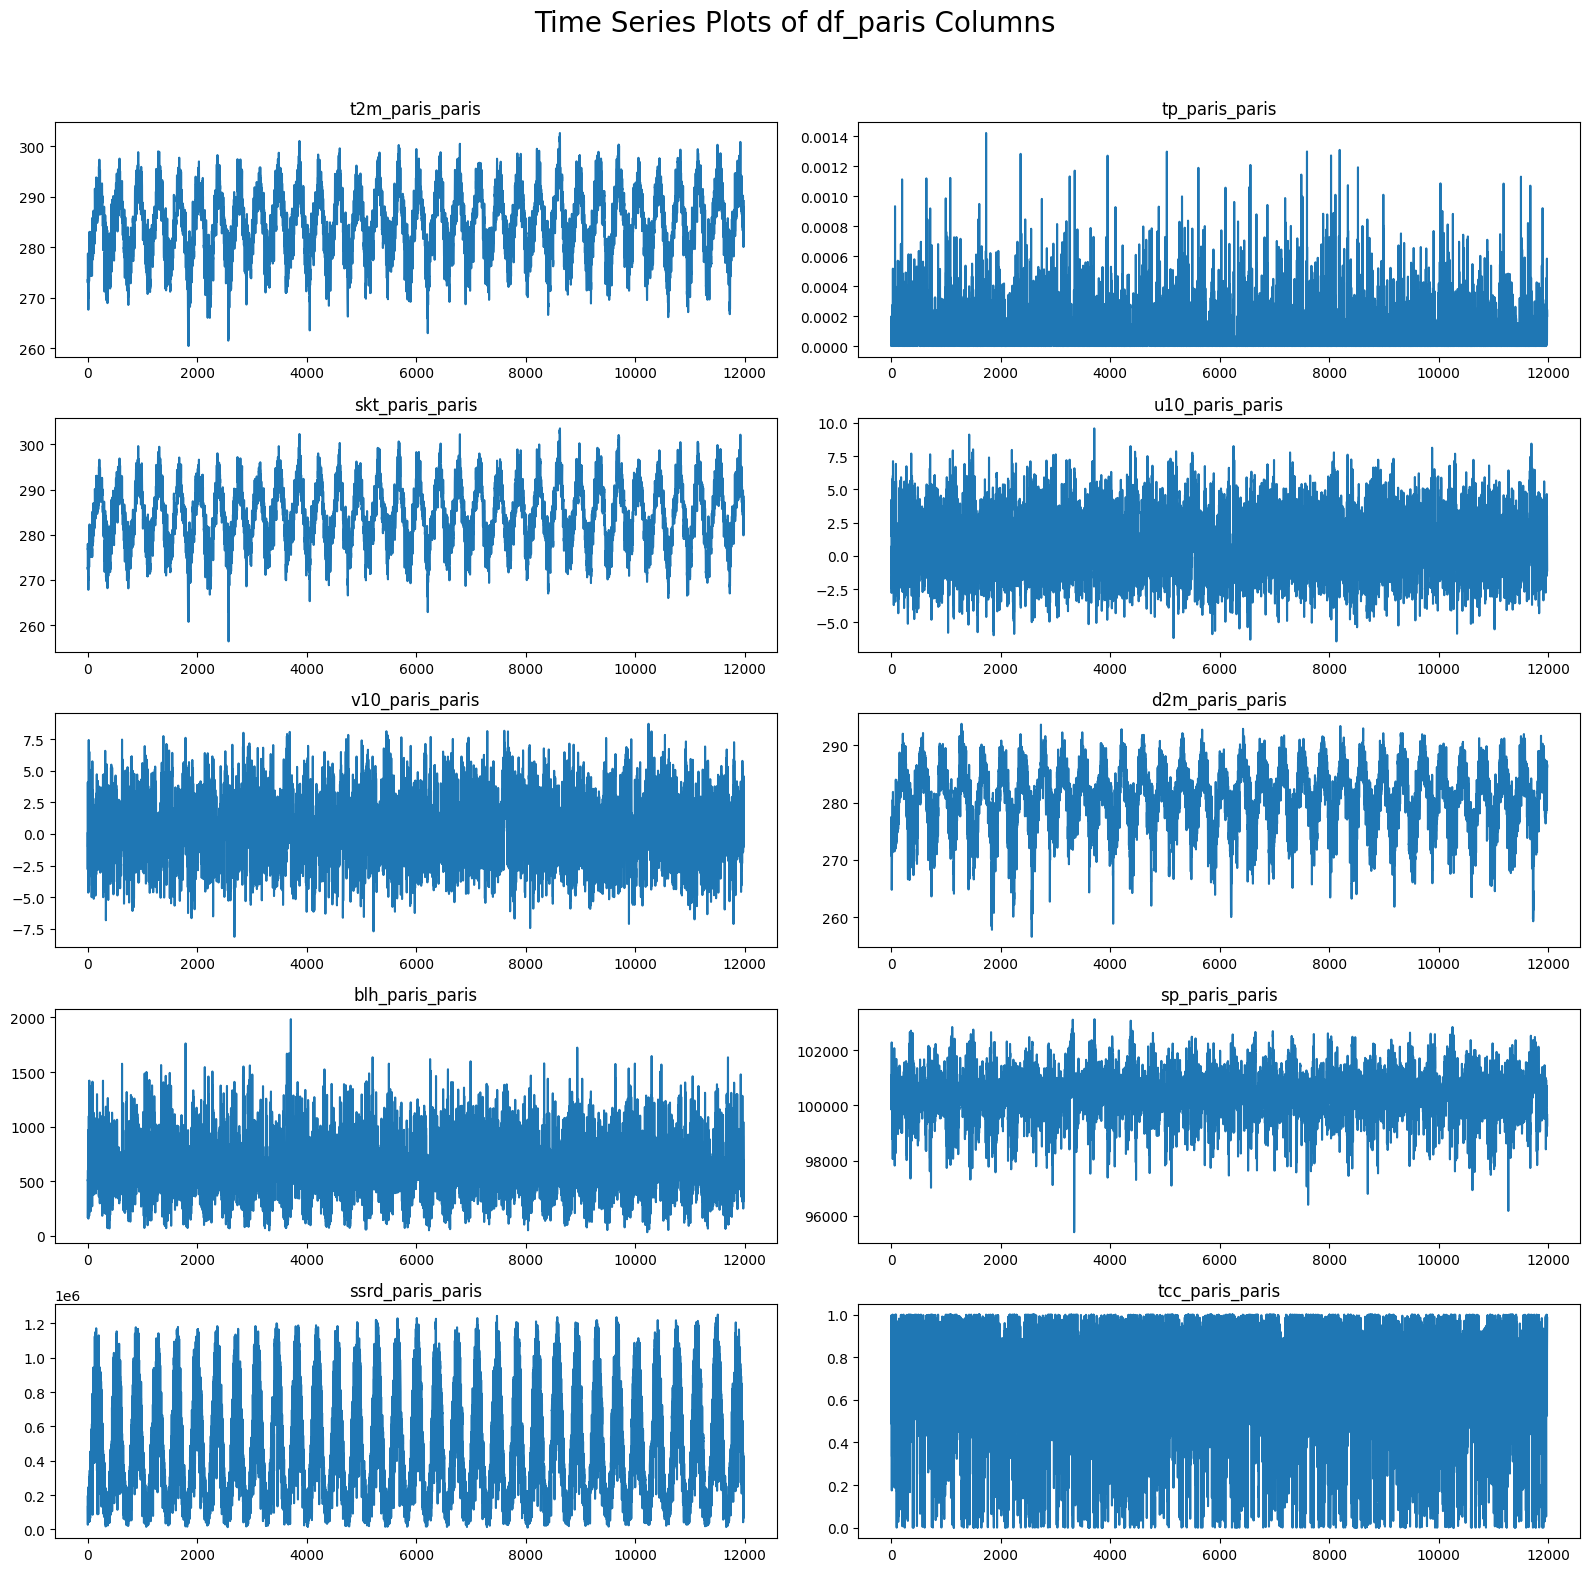

In [35]:
plt.figure(figsize=(16, 16))
plt.suptitle("Time Series Plots of df_paris Columns", fontsize=20)  # Global title

for i, c in enumerate(df_paris.columns):
    plt.subplot(5, 2, i + 1)
    df_paris[c].plot()
    plt.title(c)  # Set title for each subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the global title
plt.show()

### Data distribution for each variable, in hourly and daily cases.

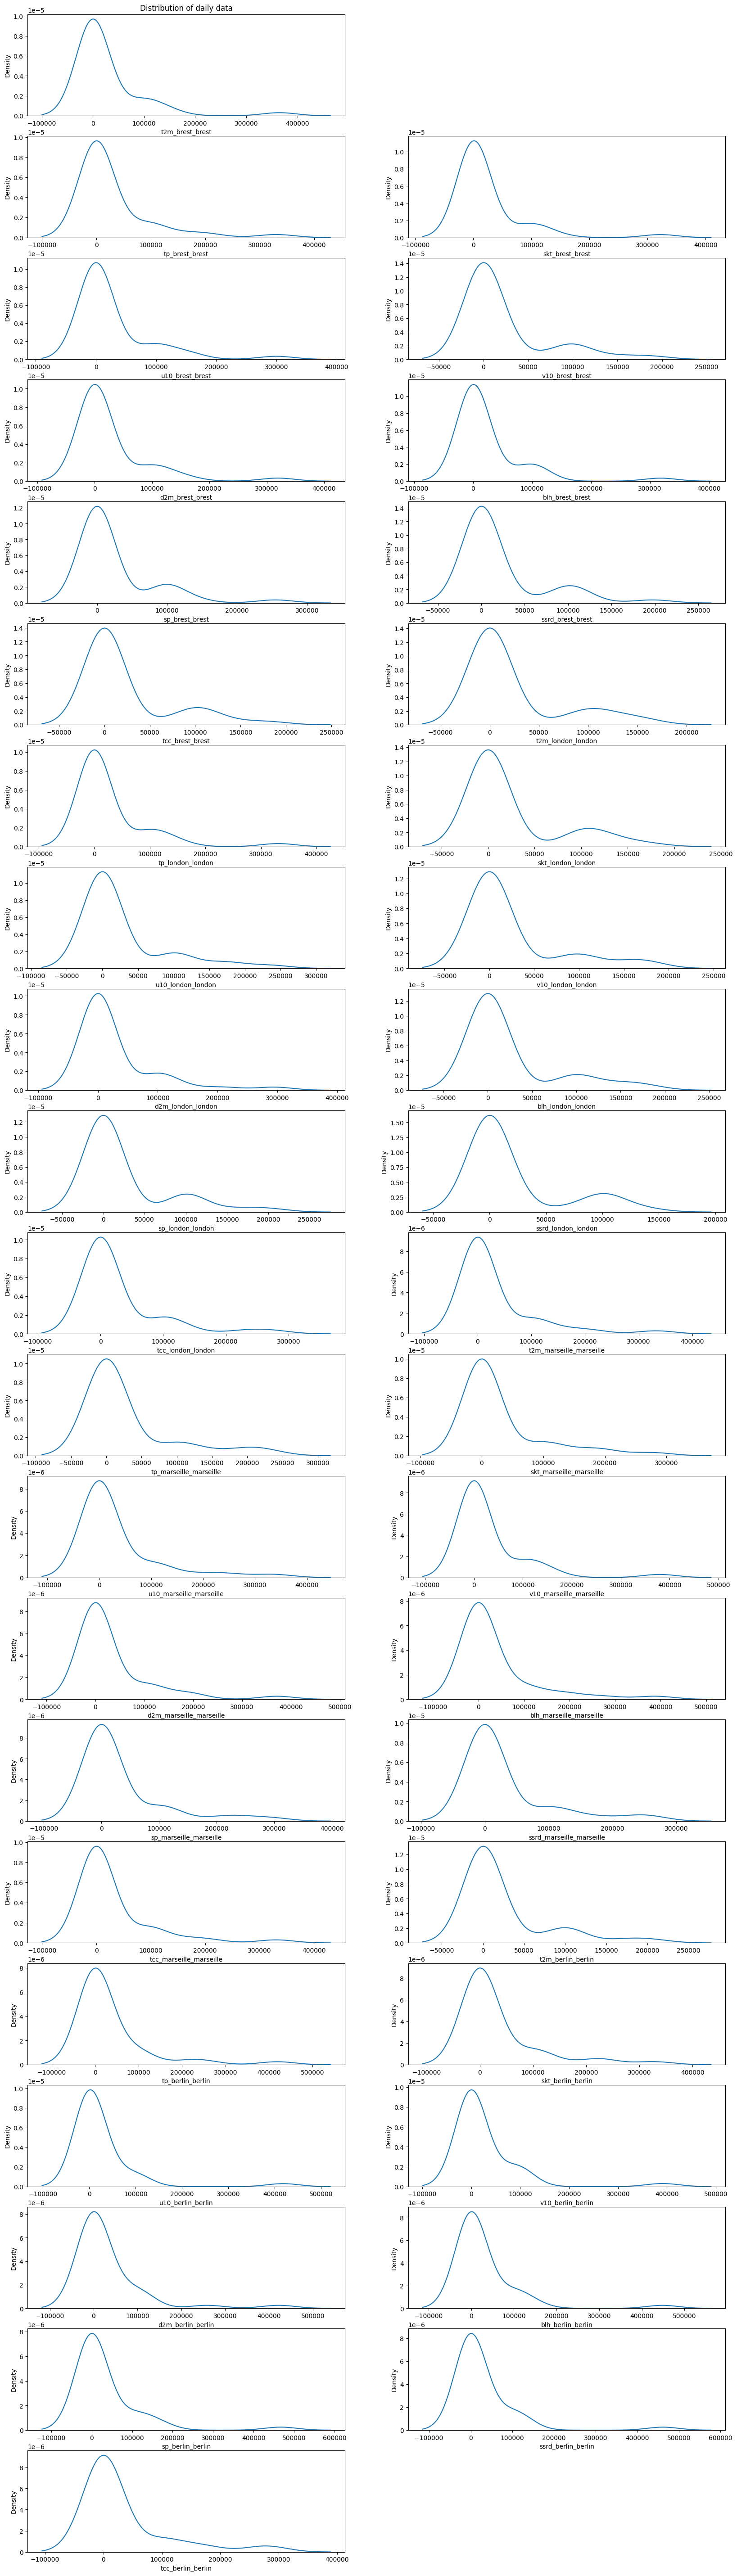

In [37]:
plt.figure(figsize=(20,140))
plt.subplot(X.shape[1],2,1)
sns.kdeplot(X.iloc[0])
plt.xlabel(X.columns[0])
plt.title('Distribution of daily data')
j=3
for i in range (1, X.shape[1]):
    plt.subplot(X.shape[1],2,j)
    sns.kdeplot(X.iloc[i])
    plt.xlabel(X.columns[i])
    j=j+1



As seen in almost all variables, in the hourly case, there are some extreme values caused by fluctuations during certain hours. 

Aggregation eliminates those extreme values, making the data more stable and efficient for capturing the average across one day.

## Modelling

In [39]:
# We align X and Y_day.
X_aligned, Y_aligned = X.align(Y, join='inner', axis=0)

# Dividing into en train and test
# Ensure index is datetime
X_aligned.index = pd.to_datetime(X_aligned.index)
Y_aligned.index = pd.to_datetime(Y_aligned.index)

# Sort by date
X_aligned = X_aligned.sort_index()
Y_aligned = Y_aligned.sort_index()

# Split Data Properly into Train and Test
split_ratio = 0.8  # 80% train, 20% test
split_index = int(len(X_aligned) * split_ratio)

X_train = X_aligned.iloc[:split_index]
Y_train = Y_aligned.iloc[:split_index]

X_test = X_aligned.iloc[split_index:]
Y_test = Y_aligned.iloc[split_index:]

# Multi-output linear regression model.
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation per variable
rmse_values = {}
r2_values = {}

for i, var in enumerate(variables):
    rmse_val = root_mean_squared_error(Y_test[var + "_paris"], Y_pred[:, i])
    r2_val = r2_score(Y_test[var + "_paris"], Y_pred[:, i])
    rmse_values[var] = rmse_val
    r2_values[var] = r2_val
    print(f"{var}: RMSE={rmse_val}, R2={r2_val}")


t2m: RMSE=1.50760984593201, R2=0.9454939019225054
tp: RMSE=0.00011314373521477491, R2=0.3087907094056346
skt: RMSE=1.5051818567922046, R2=0.9507015404116244
u10: RMSE=0.6897020993252571, R2=0.9098198149892949
v10: RMSE=0.8721441093357187, R2=0.8857079247650715
d2m: RMSE=1.6718174841428373, R2=0.9047207964982252
blh: RMSE=165.32133568186492, R2=0.6196189901240995
sp: RMSE=75.68322468266129, R2=0.9926568736773906
ssrd: RMSE=149137.61197110653, R2=0.7768937201634426
tcc: RMSE=0.20302919874834513, R2=0.46806168768784007


We can see that linear regression performs very well on 6 of the 10 variables to be predicted, so we'll see if it's possible to reduce the number of features used to speed up the program without too great a degradation in performance on 6 variables. For each variable, we will use the top ten variables it depends on. The number 10 was chosen after testing different values between 1 and 40 (the total number of variables), and ten was found to be the most appropriate. 

For the other 4 variables, we got resonable performance for ssrd, but there is still room for improvement. Blh and tcc showed moderate generalization with acceptable RMSE values considering the scale of the variables. 

However, for tp, the RMSE was very low, but the generalization was poor due to the highly imbalanced distribution and the significant proportion of zero values.

### Predicting u10

In [40]:
y_u10 = Y['u10_paris']  #'u10' as target

In [41]:
X.shape , y_u10.shape

((11981, 40), (11981,))

In [42]:
X_cleaned, y_u10_cleaned = X.align(y_u10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_u10_cleaned.shape)

(11981, 40)
(11981,)


In [43]:
correlations_selected_u10 = X_cleaned.corrwith(y_u10_cleaned).sort_values(ascending=False)
print("Variables most correlated with u10_paris:")
print(correlations_selected_u10.head(10))

Variables most correlated with u10_paris:
u10_brest_brest            0.834739
u10_london_london          0.833786
v10_berlin_berlin          0.528932
blh_brest_brest            0.528381
blh_london_london          0.507955
u10_marseille_marseille    0.507947
tp_berlin_berlin           0.354493
u10_berlin_berlin          0.339369
tcc_berlin_berlin          0.269600
tcc_brest_brest            0.261229
dtype: float64


In [44]:
selected_features_u10 = correlations_selected_u10.head(10).index
X_selected_u10 = X_cleaned[selected_features_u10]
y_u10_selected = y_u10_cleaned
X_train_u10, X_test_u10, y_train_u10, y_test_u10 = train_test_split(X_selected_u10, y_u10_selected, test_size=0.2, random_state=42)
model_u10 = LinearRegression()
model_u10.fit(X_train_u10, y_train_u10)
y_pred_u10_train = model_u10.predict(X_train_u10)
y_pred_u10 = model_u10.predict(X_test_u10)

rmse_u10_train = root_mean_squared_error(y_train_u10, y_pred_u10_train)
r2_u10_train = r2_score(y_train_u10, y_pred_u10_train)

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE_train: {rmse_u10_train}")
print(f"R2_train: {r2_u10_train}")

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

RMSE_train: 0.9331933011236403
R2_train: 0.8493949006443855
RMSE: 0.8982640511124533
R2: 0.8593920356815636


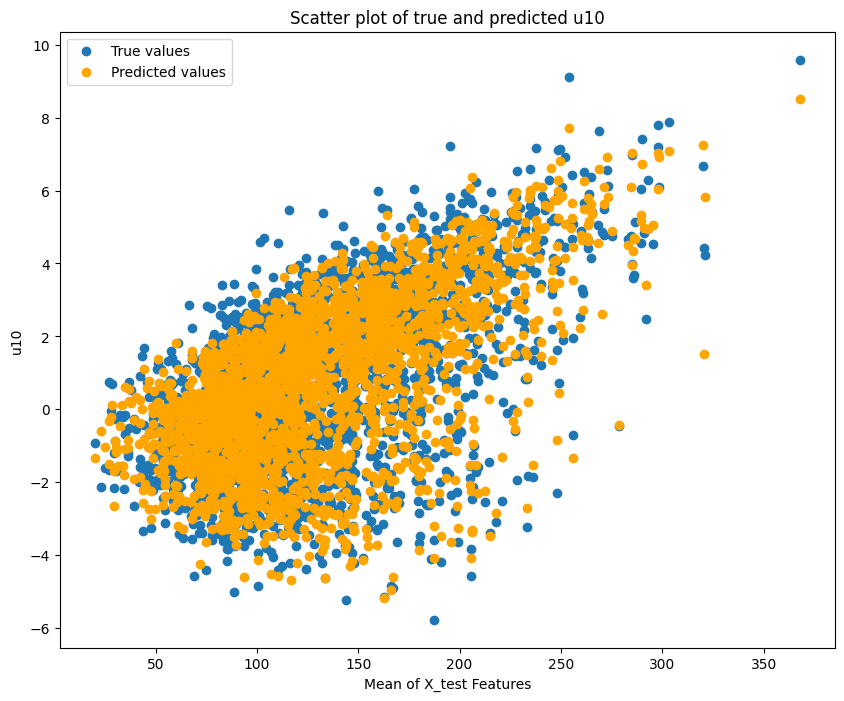

In [45]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

Now, let's use a cross-validation approach.

In [46]:
model_u10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='r2',
    cv=cv
)

# We calculate the mean and the standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

Cross-validated RMSE: 0.9344 ± 0.0138
Cross-validated R²: 0.8489 ± 0.0033
RMSE: 0.8982640511124533
R2: 0.8593920356815636


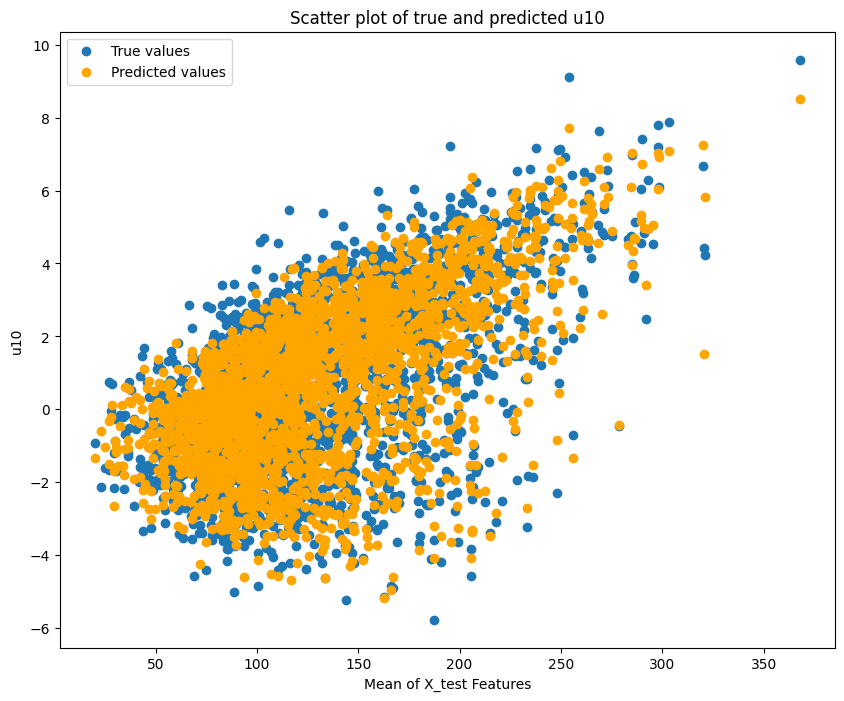

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

We obtained close values, which indicates the model's consistency and robustness.

Now we repeat everything we did with the variable u10 for the other variables.

### Predicting v10

In [48]:
y_v10 = Y['v10_paris']  # 'v10' as target

In [49]:
X.shape , y_v10.shape

((11981, 40), (11981,))

In [50]:
X_cleaned, y_v10_cleaned = X.align(y_v10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_v10_cleaned.shape)

(11981, 40)
(11981,)


In [51]:
correlations_selected_v10 = X_cleaned.corrwith(y_v10_cleaned).sort_values(ascending=False)
print("Variables most correlated with v10_paris:")
print(correlations_selected_v10.head(10))

Variables most correlated with v10_paris:
v10_london_london    0.758255
v10_brest_brest      0.660015
u10_brest_brest      0.650458
v10_berlin_berlin    0.647514
tp_brest_brest       0.519095
tp_london_london     0.468236
tcc_brest_brest      0.387889
blh_brest_brest      0.335580
u10_london_london    0.321289
tcc_london_london    0.307230
dtype: float64


In [52]:
selected_features_v10 = correlations_selected_v10.head(10).index
X_selected_v10 = X_cleaned[selected_features_v10]
y_v10_selected = y_v10_cleaned
X_train_v10, X_test_v10, y_train_v10, y_test_v10 = train_test_split(X_selected_v10, y_v10_selected, test_size=0.2, random_state=42)

model_v10 = LinearRegression()
model_v10.fit(X_train_v10, y_train_v10)

y_pred_v10_train = model_v10.predict(X_train_v10)
y_pred_v10 = model_v10.predict(X_test_v10)

rmse_v10_train = root_mean_squared_error(y_train_v10, y_pred_v10_train)
r2_v10_train = r2_score(y_train_v10, y_pred_v10_train)

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE_train: {rmse_v10_train}")
print(f"R2_train: {r2_v10_train}")

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

RMSE_train: 1.1099295856676217
R2_train: 0.819025691790472
RMSE: 1.1250982122038085
R2: 0.8101599772945038


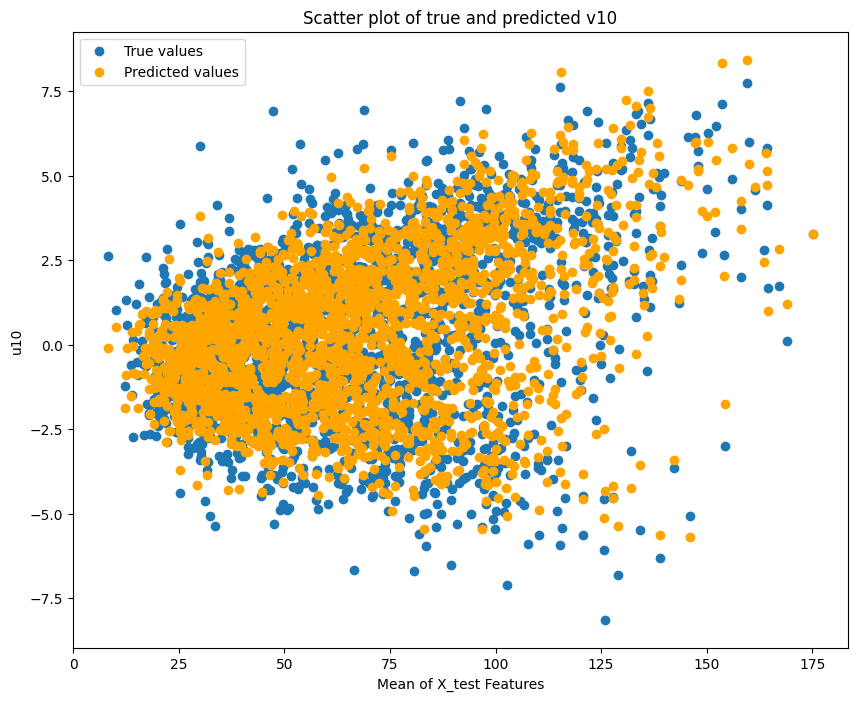

In [53]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_v10.mean(axis=1), y_test_v10, label='True values')
plt.scatter(X_test_v10.mean(axis=1), y_pred_v10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted v10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [54]:
model_v10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

Cross-validated RMSE: 1.1121 ± 0.0075
Cross-validated R²: 0.8181 ± 0.0070
RMSE: 1.1250982122038085
R2: 0.8101599772945038


### Predicting t2m

In [55]:
y_t2m = Y['t2m_paris']  #'t2m' as target

In [56]:
X.shape , y_t2m.shape

((11981, 40), (11981,))

In [57]:
X_cleaned, y_t2m_cleaned = X.align(y_t2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_t2m_cleaned.shape)

(11981, 40)
(11981,)


In [58]:
correlations_selected_t2m = X_cleaned.corrwith(y_t2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with t2m_paris:")
print(correlations_selected_t2m.head(10))

Variables most correlated with t2m_paris:
skt_london_london          0.949240
t2m_london_london          0.947109
skt_brest_brest            0.927390
t2m_brest_brest            0.917009
skt_berlin_berlin          0.905832
t2m_marseille_marseille    0.905610
t2m_berlin_berlin          0.902288
d2m_london_london          0.883579
skt_marseille_marseille    0.879278
d2m_brest_brest            0.874065
dtype: float64


In [59]:
selected_features_t2m = correlations_selected_t2m.head(10).index
X_selected_t2m = X_cleaned[selected_features_t2m]
y_t2m_selected = y_t2m_cleaned
X_train_t2m, X_test_t2m, y_train_t2m, y_test_t2m = train_test_split(X_selected_t2m, y_t2m_selected, test_size=0.2, random_state=42)

model_t2m = LinearRegression()
model_t2m.fit(X_train_t2m, y_train_t2m)

y_pred_t2m_train = model_t2m.predict(X_train_t2m)
y_pred_t2m = model_t2m.predict(X_test_t2m)

rmse_t2m_train = root_mean_squared_error(y_train_t2m, y_pred_t2m_train)
r2_t2m_train = r2_score(y_train_t2m, y_pred_t2m_train)

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE_train: {rmse_t2m_train}")
print(f"R2_train: {r2_t2m_train}")

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

RMSE_train: 1.6263217892468587
R2_train: 0.9372633507472163
RMSE: 1.5879856876871523
R2: 0.9399508452349244


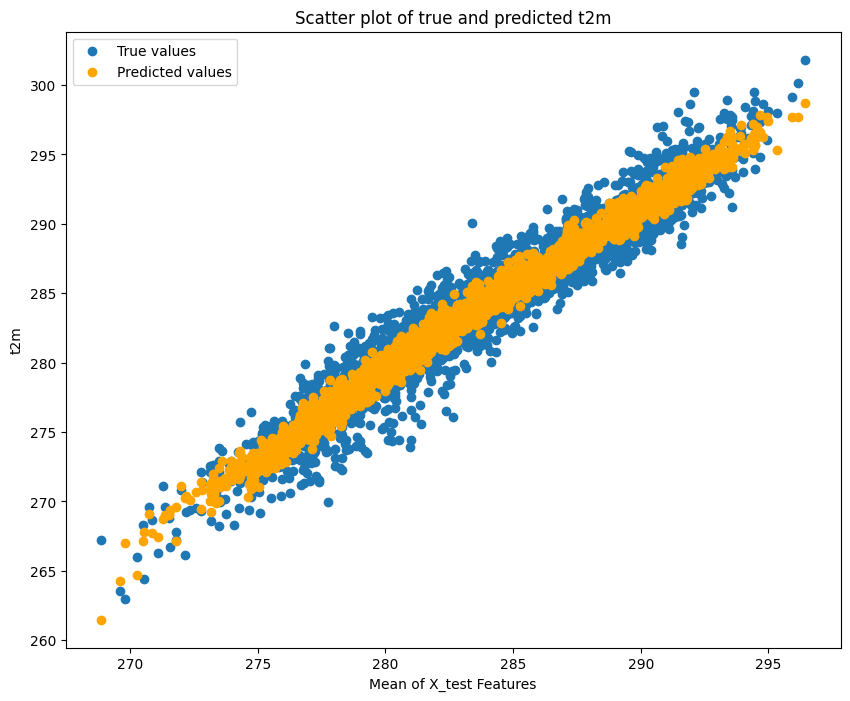

In [60]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [61]:
model_t2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

Cross-validated RMSE: 1.6277 ± 0.0151
Cross-validated R²: 0.9371 ± 0.0016
RMSE: 1.5879856876871523
R2: 0.9399508452349244


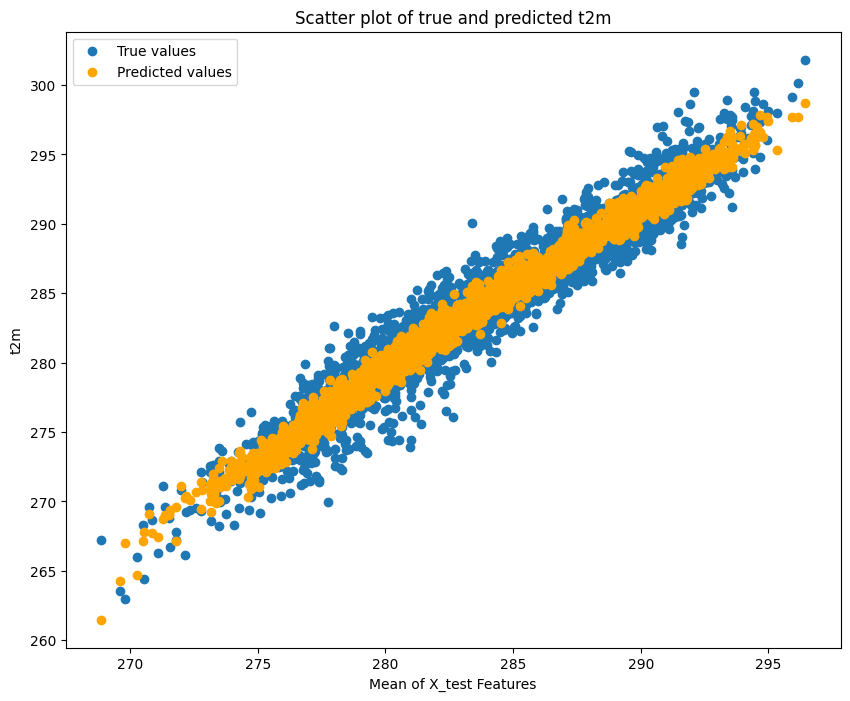

In [62]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting d2m

In [63]:
y_d2m = Y['d2m_paris']  #'d2m' as target

In [64]:
X.shape , y_d2m.shape

((11981, 40), (11981,))

In [65]:
X_cleaned, y_d2m_cleaned = X.align(y_d2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_d2m_cleaned.shape)

(11981, 40)
(11981,)


In [66]:
correlations_selected_d2m = X_cleaned.corrwith(y_d2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with d2m_paris:")
print(correlations_selected_d2m.head(10))

Variables most correlated with d2m_paris:
d2m_london_london          0.900937
d2m_brest_brest            0.891871
t2m_london_london          0.891059
skt_london_london          0.883903
t2m_brest_brest            0.878685
skt_brest_brest            0.871447
t2m_berlin_berlin          0.851575
skt_berlin_berlin          0.849369
t2m_marseille_marseille    0.840410
d2m_berlin_berlin          0.832115
dtype: float64


In [67]:
selected_features_d2m = correlations_selected_d2m.head(10).index
X_selected_d2m = X_cleaned[selected_features_d2m]
y_d2m_selected = y_d2m_cleaned
X_train_d2m, X_test_d2m, y_train_d2m, y_test_d2m = train_test_split(X_selected_d2m, y_d2m_selected, test_size=0.2, random_state=42)

model_d2m = LinearRegression()
model_d2m.fit(X_train_d2m, y_train_d2m)

y_pred_d2m_train = model_d2m.predict(X_train_d2m)
y_pred_d2m = model_d2m.predict(X_test_d2m)

rmse_d2m_train = root_mean_squared_error(y_train_d2m, y_pred_d2m_train)
r2_d2m_train = r2_score(y_train_d2m, y_pred_d2m_train)

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE_train: {rmse_d2m_train}")
print(f"R2_train: {r2_d2m_train}")

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

RMSE_train: 1.883394265250099
R2_train: 0.8860162219084474
RMSE: 1.8533183528555925
R2: 0.8908230524206896


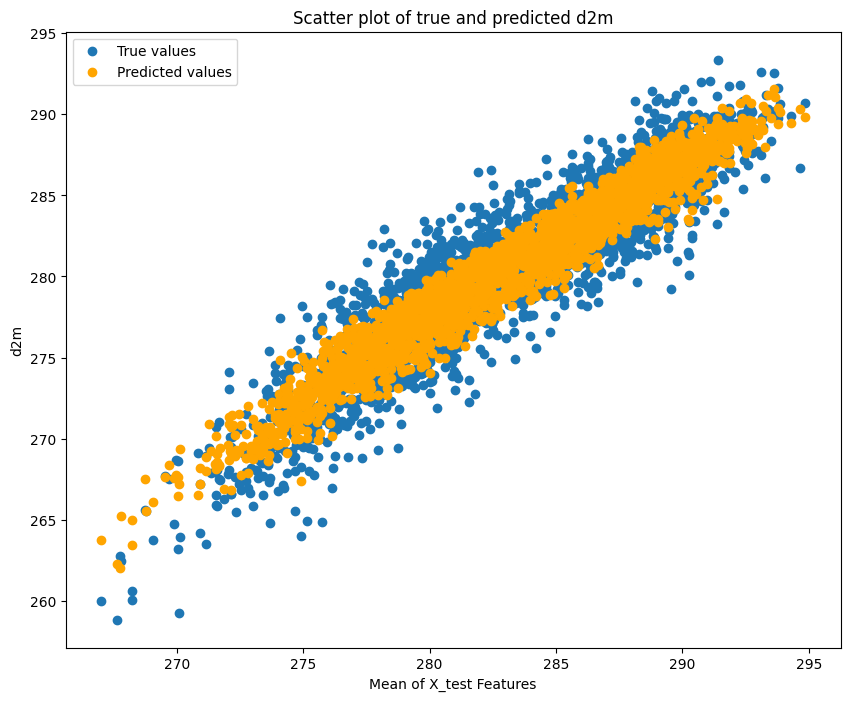

In [68]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [69]:
model_d2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

Cross-validated RMSE: 1.8860 ± 0.0212
Cross-validated R²: 0.8856 ± 0.0035
RMSE: 1.8533183528555925
R2: 0.8908230524206896


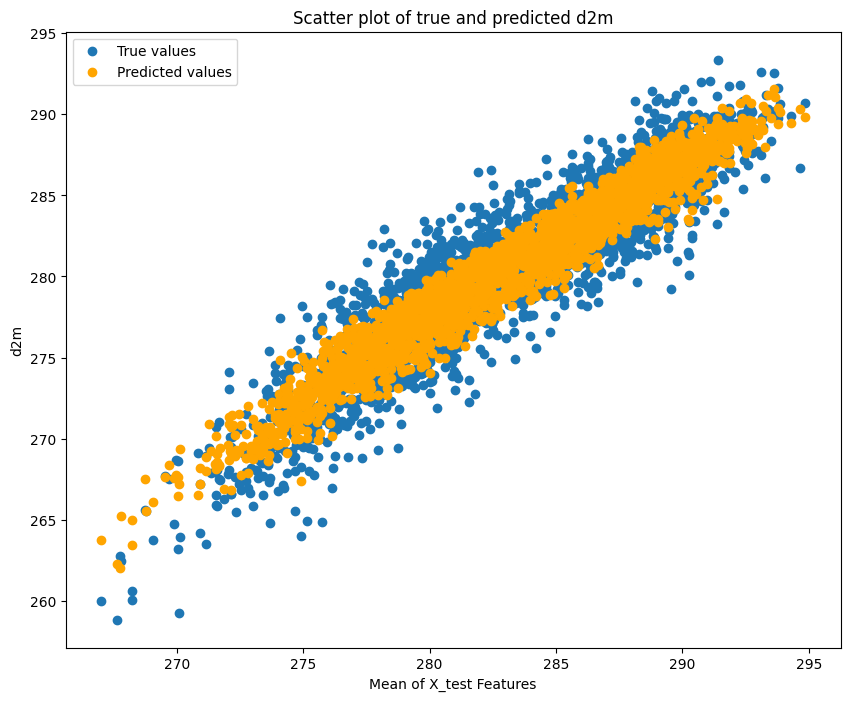

In [70]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting skt

In [71]:
y_skt = Y['skt_paris']  #'skt' as target

In [72]:
X.shape , y_skt.shape

((11981, 40), (11981,))

In [73]:
X_cleaned, y_skt_cleaned = X.align(y_skt, join='inner', axis=0)
print(X_cleaned.shape)
print(y_skt_cleaned.shape)

(11981, 40)
(11981,)


In [74]:
correlations_selected_skt = X_cleaned.corrwith(y_skt_cleaned).sort_values(ascending=False)
print("Variables most correlated with skt_paris:")
print(correlations_selected_skt.head(10))

Variables most correlated with skt_paris:
skt_london_london          0.954819
t2m_london_london          0.946868
skt_brest_brest            0.936471
t2m_marseille_marseille    0.919634
t2m_brest_brest            0.915887
skt_berlin_berlin          0.915322
t2m_berlin_berlin          0.907848
skt_marseille_marseille    0.899225
d2m_london_london          0.876559
d2m_brest_brest            0.866718
dtype: float64


In [75]:
selected_features_skt = correlations_selected_skt.head(10).index
X_selected_skt = X_cleaned[selected_features_skt]
y_skt_selected = y_skt_cleaned
X_train_skt, X_test_skt, y_train_skt, y_test_skt = train_test_split(X_selected_skt, y_skt_selected, test_size=0.2, random_state=42)

model_skt = LinearRegression()
model_skt.fit(X_train_skt, y_train_skt)

y_pred_skt_train = model_skt.predict(X_train_skt)
y_pred_skt = model_skt.predict(X_test_skt)

rmse_skt_train = root_mean_squared_error(y_train_skt, y_pred_skt_train)
r2_skt_train = r2_score(y_train_skt, y_pred_skt_train)

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE_train: {rmse_skt_train}")
print(f"R2_train: {r2_skt_train}")

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

RMSE_train: 1.577622911178826
R2_train: 0.9449818160502902
RMSE: 1.5175033980320924
R2: 0.9488459787712068


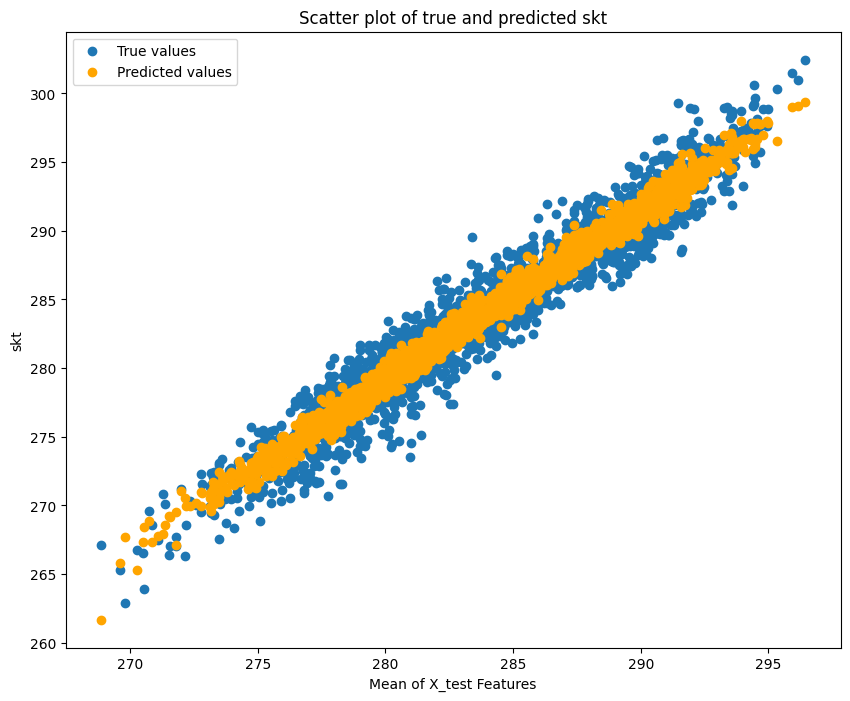

In [76]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [77]:
model_skt_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

Cross-validated RMSE: 1.5791 ± 0.0142
Cross-validated R²: 0.9448 ± 0.0016
RMSE: 1.5175033980320924
R2: 0.9488459787712068


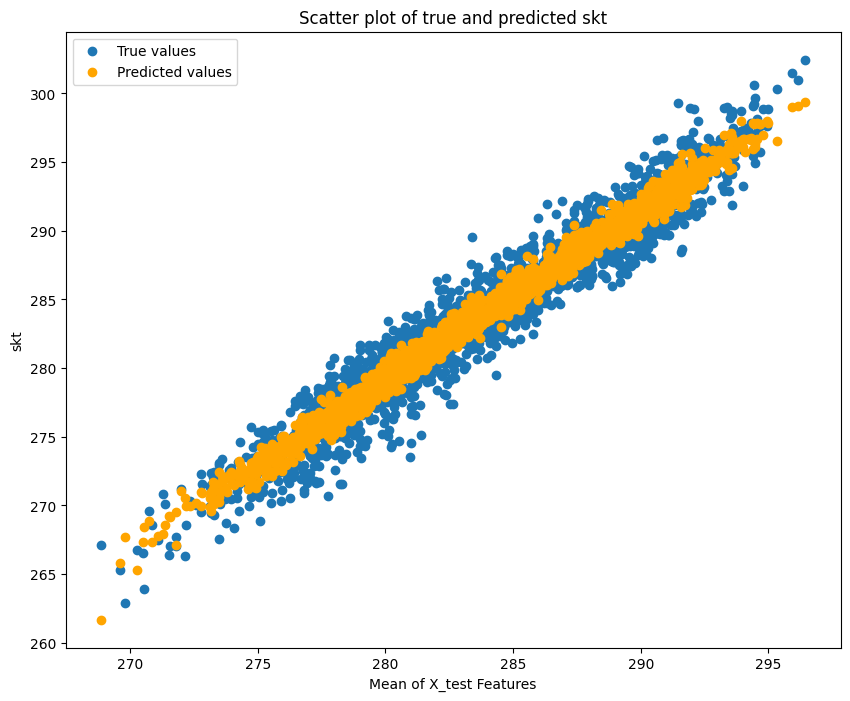

In [78]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### predicting sp

In [79]:
y_sp = Y['sp_paris']  #'sp' as target

In [80]:
X.shape , y_sp.shape

((11981, 40), (11981,))

In [81]:
X_cleaned, y_sp_cleaned = X.align(y_sp, join='inner', axis=0)
print(X_cleaned.shape)
print(y_sp_cleaned.shape)

(11981, 40)
(11981,)


In [82]:
correlations_selected_sp = X_cleaned.corrwith(y_sp_cleaned).sort_values(ascending=False)
print("Variables most correlated with sp_paris:")
print(correlations_selected_sp.head(10))

Variables most correlated with sp_paris:
sp_brest_brest              0.926810
sp_london_london            0.923580
sp_berlin_berlin            0.726258
sp_marseille_marseille      0.573130
u10_berlin_berlin           0.325525
blh_berlin_berlin           0.070580
ssrd_marseille_marseille    0.068514
u10_marseille_marseille     0.034242
u10_london_london           0.030859
ssrd_brest_brest            0.026553
dtype: float64


In [83]:
selected_features_sp = correlations_selected_sp.head(10).index
X_selected_sp = X_cleaned[selected_features_sp]
y_sp_selected = y_sp_cleaned
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_selected_sp, y_sp_selected, test_size=0.2, random_state=42)

model_sp = LinearRegression()
model_sp.fit(X_train_sp, y_train_sp)

y_pred_sp_train = model_sp.predict(X_train_sp)
y_pred_sp = model_sp.predict(X_test_sp)

rmse_sp_train = root_mean_squared_error(y_train_sp, y_pred_sp_train)
r2_sp_train = r2_score(y_train_sp, y_pred_sp_train)

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE_train: {rmse_sp_train}")
print(f"R2_train: {r2_sp_train}")

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

RMSE_train: 131.1055454477364
R2_train: 0.9779125496375124
RMSE: 128.1520425304516
R2: 0.9778890808080734


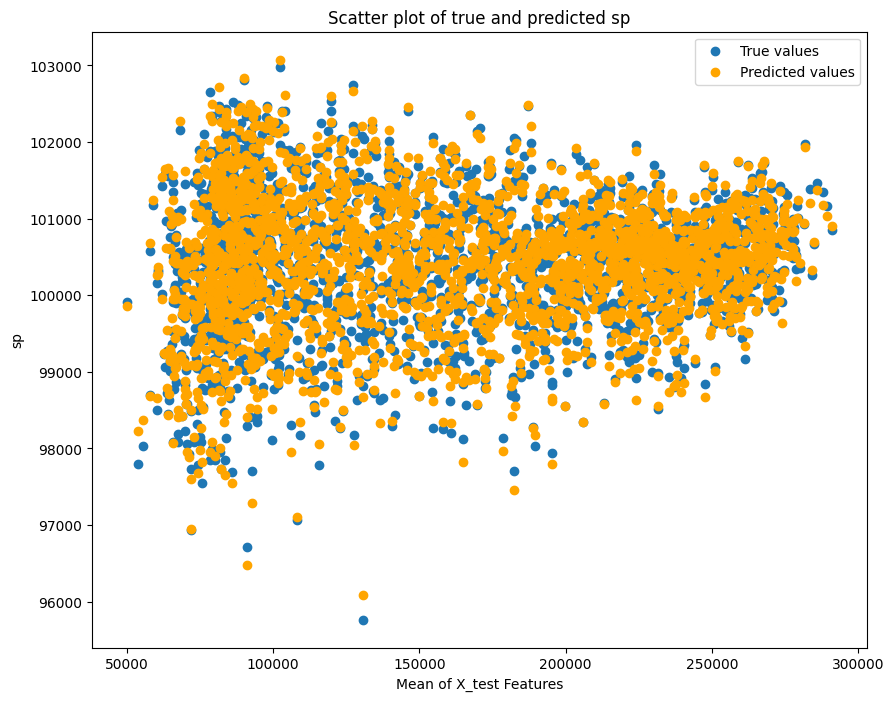

In [84]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [85]:
model_sp_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

Cross-validated RMSE: 131.2540 ± 2.1128
Cross-validated R²: 0.9778 ± 0.0018
RMSE: 128.1520425304516
R2: 0.9778890808080734


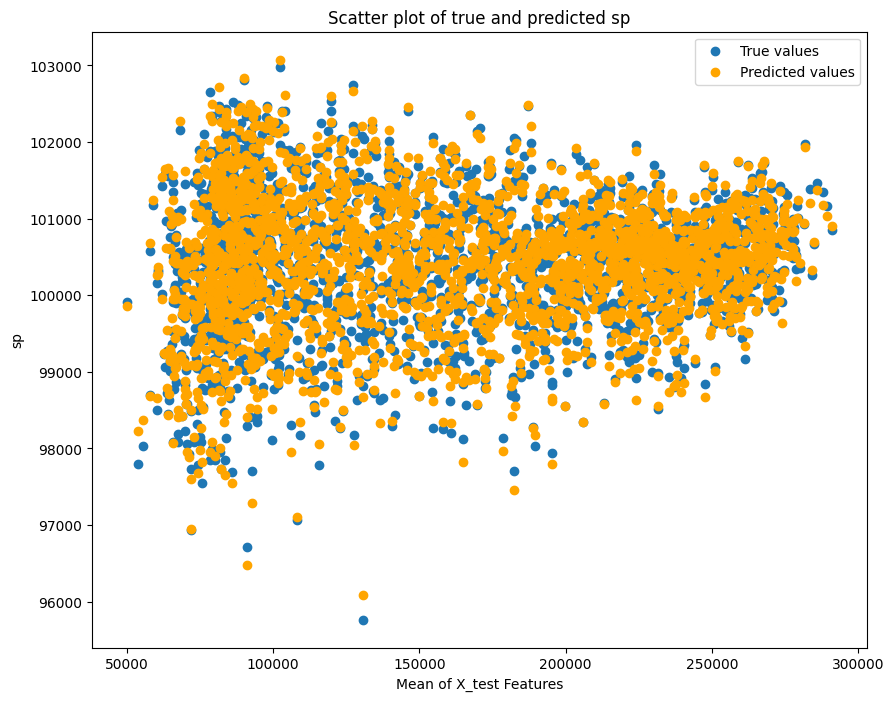

In [86]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

##### Now, let's focus on the other four variables: ssrd, blh, tcc, and tp.

## Improve performances

At the beginning, we used GridSearchCV with several models, each tested with multiple variables. We observed that XGBoostRegressor was the most performant model, but the GridSearchCV process was very time-consuming. Therefore, we switched to RandomizedSearchCV with XGBoostRegressor and achieved almost the same results with a significantly shorter execution time compared to GridSearchCV.

In [87]:
# RandomizedSearchCV parameters
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Number of iterations and number of folds RandomizedSearchCV
n_iter_search = 20
cv_folds = 3

### Predicting ssrd

In [88]:
# Target variable
var = 'ssrd_paris'

# Training initial model
initial_model_ssrd = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_ssrd.fit(X_train, Y_train[var])

# Initial predictions
preds_initial_ssrd = initial_model_ssrd.predict(X_test)

# Initiale evaluation
rmse_init_ssrd = root_mean_squared_error(Y_test[var], preds_initial_ssrd)
r2_init_ssrd = r2_score(Y_test[var], preds_initial_ssrd)
print(f"{var} - Initial: RMSE={rmse_init_ssrd:.4f}, R²={r2_init_ssrd:.4f}")

# Optimisation of hyperparameters
search_ssrd = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_ssrd.fit(X_train, Y_train[var])

# Best model
best_model_ssrd = search_ssrd.best_estimator_
best_model_ssrd.fit(X_train, Y_train[var])

# Otimized predictions
preds_best_ssrd = best_model_ssrd.predict(X_test)

# Evaluation
rmse_best_ssrd = root_mean_squared_error(Y_test[var], preds_best_ssrd)
r2_best_ssrd = r2_score(Y_test[var], preds_best_ssrd)
print(f"{var} - Optimisé: RMSE={rmse_best_ssrd:.4f}, R²={r2_best_ssrd:.4f}")
print(f"Meilleurs paramètres : {search_ssrd.best_params_}")

ssrd_paris - Initial: RMSE=138522.2717, R²=0.8075
ssrd_paris - Optimisé: RMSE=137539.5841, R²=0.8102
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


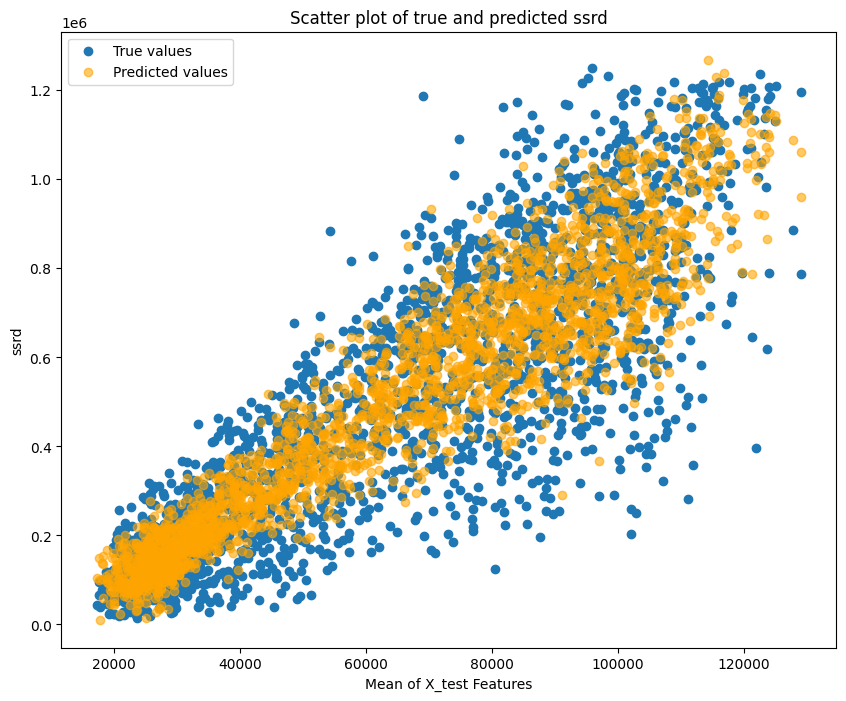

In [89]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_ssrd, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted ssrd')
plt.xlabel('Mean of X_test Features')
plt.ylabel('ssrd')
plt.legend()
plt.show()

As seen, we obtain strong performance for the ssrd model, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### Predicting blh

In [90]:
var = 'blh_paris'

initial_model_blh = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_blh.fit(X_train, Y_train[var])

preds_initial_blh = initial_model_blh.predict(X_test)

rmse_init_blh = root_mean_squared_error(Y_test[var], preds_initial_blh)
r2_init_blh = r2_score(Y_test[var], preds_initial_blh)
print(f"{var} - Initial: RMSE={rmse_init_blh:.4f}, R²={r2_init_blh:.4f}")

search_blh = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_blh.fit(X_train, Y_train[var])

best_model_blh = search_blh.best_estimator_
best_model_blh.fit(X_train, Y_train[var])

preds_best_blh = best_model_blh.predict(X_test)

rmse_best_blh = root_mean_squared_error(Y_test[var], preds_best_blh)
r2_best_blh = r2_score(Y_test[var], preds_best_blh)
print(f"{var} - Optimisé: RMSE={rmse_best_blh:.4f}, R²={r2_best_blh:.4f}")
print(f"Meilleurs paramètres : {search_blh.best_params_}")

blh_paris - Initial: RMSE=139.0795, R²=0.7308
blh_paris - Optimisé: RMSE=140.8117, R²=0.7240
Meilleurs paramètres : {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


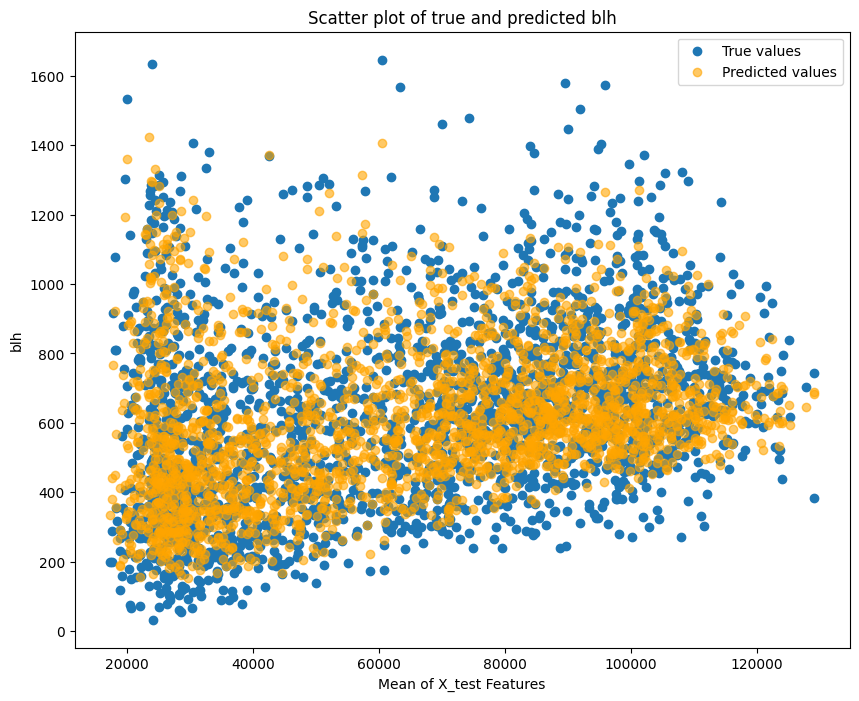

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_blh, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted blh')
plt.xlabel('Mean of X_test Features')
plt.ylabel('blh')
plt.legend()
plt.show()

We achieved an RMSE reduction of approximately 30 and an improvement of 0.13 compared to linear regression.

Good performance, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### Predicting tcc

In [92]:
var = 'tcc_paris'

initial_model_tcc = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_tcc.fit(X_train, Y_train[var])

preds_initial_tcc = initial_model_tcc.predict(X_test)

rmse_init_tcc = root_mean_squared_error(Y_test[var], preds_initial_tcc)
r2_init_tcc = r2_score(Y_test[var], preds_initial_tcc)
print(f"{var} - Initial: RMSE={rmse_init_tcc:.4f}, R²={r2_init_tcc:.4f}")

search_tcc = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_tcc.fit(X_train, Y_train[var])

best_model_tcc = search_tcc.best_estimator_
best_model_tcc.fit(X_train, Y_train[var])

preds_best_tcc = best_model_tcc.predict(X_test)
rmse_best_tcc = root_mean_squared_error(Y_test[var], preds_best_tcc)
r2_best_tcc = r2_score(Y_test[var], preds_best_tcc)
print(f"{var} - Optimisé: RMSE={rmse_best_tcc:.4f}, R²={r2_best_tcc:.4f}")
print(f"Meilleurs paramètres : {search_tcc.best_params_}")

tcc_paris - Initial: RMSE=0.1920, R²=0.5244
tcc_paris - Optimisé: RMSE=0.1916, R²=0.5261
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


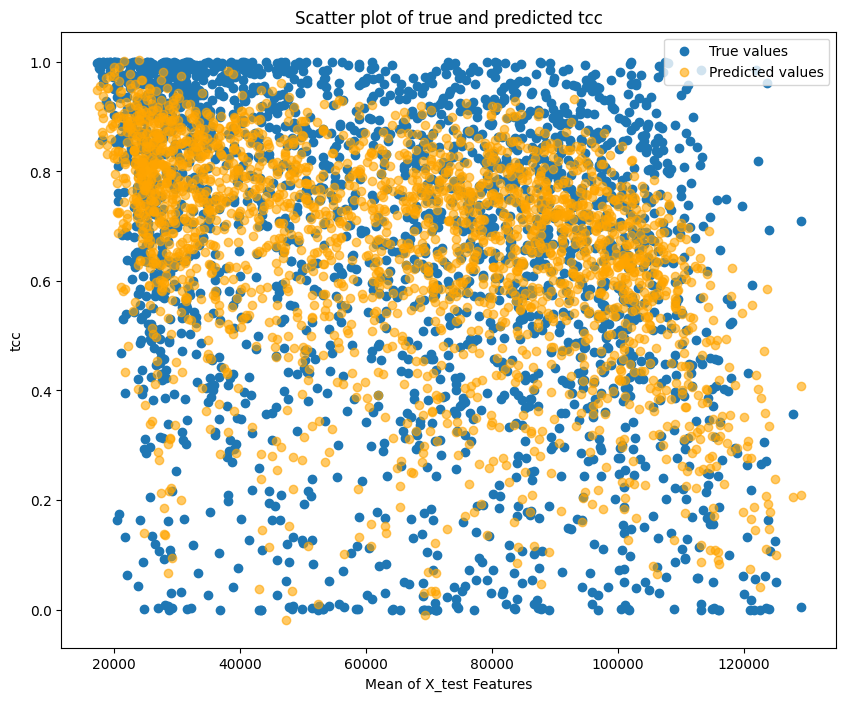

In [93]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_tcc, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted tcc')
plt.xlabel('Mean of X_test Features')
plt.ylabel('tcc')
plt.legend()
plt.show()

Good performance, with a reasonable RMSE and better than linear regression, which serves as our baseline model.

### Predicting tp

In [94]:
var = 'tp_paris'

initial_model_tp = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_tp.fit(X_train, Y_train[var])

preds_initial_tp = initial_model_tp.predict(X_test)

rmse_init_tp = root_mean_squared_error(Y_test[var], preds_initial_tp)
r2_init_tp = r2_score(Y_test[var], preds_initial_tp)
print(f"{var} - Initial: RMSE={rmse_init_tp:.4f}, R²={r2_init_tp:.4f}")

search_tp = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_tp.fit(X_train, Y_train[var])

best_model_tp = search_tp.best_estimator_
best_model_tp.fit(X_train, Y_train[var])

preds_best_tp = best_model_tp.predict(X_test)

rmse_best_tp = root_mean_squared_error(Y_test[var], preds_best_tp)
r2_best_tp = r2_score(Y_test[var], preds_best_tp)
print(f"{var} - Optimisé: RMSE={rmse_best_tp:.4f}, R²={r2_best_tp:.4f}")
print(f"Meilleurs paramètres : {search_tp.best_params_}")

tp_paris - Initial: RMSE=0.0001, R²=0.2653
tp_paris - Optimisé: RMSE=0.0001, R²=0.2668
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


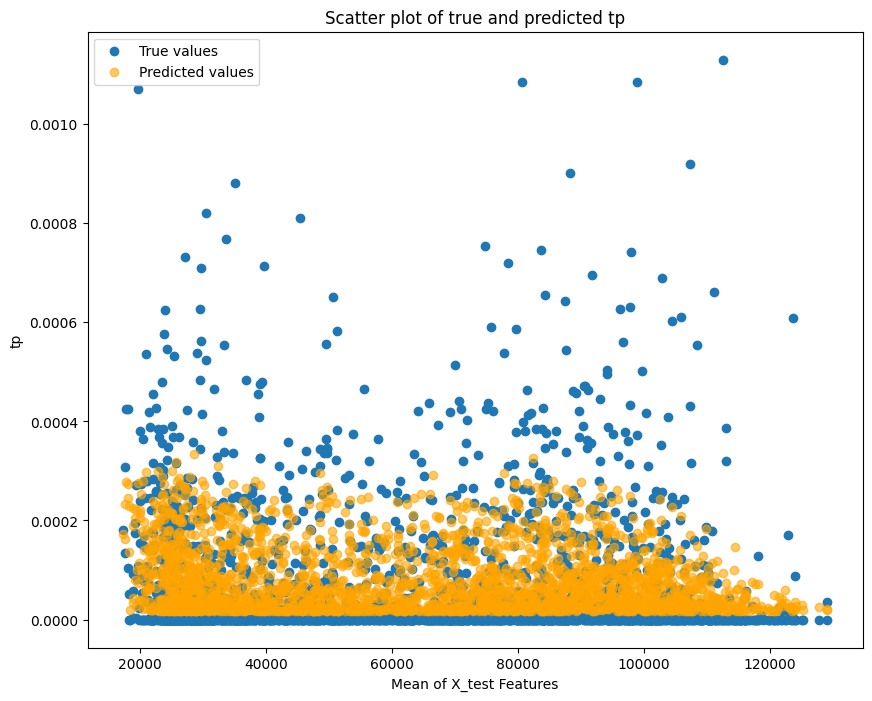

In [95]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_tp, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted tp')
plt.xlabel('Mean of X_test Features')
plt.ylabel('tp')
plt.legend()
plt.show()

Poor performances again for tp!

##### Solution: Using two sequential models:
            First model: A binary classification to predict whether precipitation occurs or not.
            Second model: A regression on data where precipitation values are strictly positive, to accurately predict the value of tp.

In [96]:
print(Y['tp_paris'].describe())
print(Y['tp_paris'].head())


count    11981.000000
mean         0.000081
std          0.000145
min          0.000000
25%          0.000000
50%          0.000015
75%          0.000098
max          0.001421
Name: tp_paris, dtype: float64
0    5.245209e-06
1    5.761782e-07
2    1.157920e-04
3    1.973510e-04
4    2.326568e-05
Name: tp_paris, dtype: float64


In [97]:
zeros_per_column_paris_day = (Y == 0).sum()

total_values_per_column_paris_day = Y.count()

zero_ratio_paris_day = zeros_per_column_paris_day / total_values_per_column_paris_day

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris_day,
    'Total Values': total_values_per_column_paris_day,
    'Zero Ratio': zero_ratio_paris_day
})

print(result)

            Zeros Count  Total Values  Zero Ratio
t2m_paris             0         11981    0.000000
tp_paris           3036         11981    0.253401
skt_paris             0         11981    0.000000
u10_paris             0         11981    0.000000
v10_paris             0         11981    0.000000
d2m_paris             0         11981    0.000000
blh_paris             0         11981    0.000000
sp_paris              0         11981    0.000000
ssrd_paris            0         11981    0.000000
tcc_paris           113         11981    0.009432


In [98]:
import xgboost as xgb

Y_aligned['tp_paris_binary'] = (Y_aligned['tp_paris'] > 0).astype(int)
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_aligned, Y_aligned['tp_paris_binary'], test_size=0.2, random_state=42
)

clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',       
    n_estimators=100,      
    learning_rate=0.1,       
    max_depth=6,         
    subsample=0.8,     
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb.fit(X_train, y_train_class)

y_pred_class = clf_xgb.predict(X_test)

print("Classification Accuracy:", accuracy_score(y_test_class,y_pred_class))

Classification Accuracy: 0.8493950771798081


In [99]:
# Identify indices where the model predicts rain
rain_indices = X_test.index[y_pred_class == 1]
no_rain_indices = X_test.index[y_pred_class == 0]

# Initialize final predictions with 0 for no-rain cases
y_pred_final = pd.Series(0, index=X_test.index)

# Perform regression only on cases where the classifier predicts rain
X_test_reg = X_test.loc[rain_indices]
y_test_reg = Y_aligned.loc[rain_indices, 'tp_paris']

# Regression model: Random Forest Regressor
non_zero = Y_aligned[Y_aligned['tp_paris'] > 0]
X_reg = X_aligned.loc[non_zero.index]
y_reg = non_zero['tp_paris']

X_train_reg, _, y_train_reg, _ = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

model_tp = RandomForestRegressor(min_samples_split= 2 ,n_estimators=200, random_state=42)
model_tp.fit(X_train_reg,y_train_reg)

# Prédiction sur les cas de pluie
y_pred_reg = model_tp.predict(X_test_reg)

# Insertion des prédictions de régression dans la série finale
y_pred_final.loc[rain_indices] = y_pred_reg

# Calcul des métriques finales
y_test_final = Y_aligned.loc[X_test.index, 'tp_paris']
rmse = np.sqrt(root_mean_squared_error(y_test_final, y_pred_final))
r2 = r2_score(y_test_final, y_pred_final)

print("Final RMSE:", rmse)
print("Final R2 Score:",r2)

Final RMSE: 0.008282163147081502
Final R2 Score: 0.7684089952600281


/var/folders/rp/t8n6frmn1nl0lx87mkxn8pth0000gn/T/ipykernel_17948/4032385205.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.39213971e-05 1.70142648e-04 1.48079917e-04 ... 1.16330700e-04
 1.88939471e-04 8.03210848e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_pred_final.loc[rain_indices] = y_pred_reg


For the classification model:  We got high accuracy, so can predict well the days without precipitation. 

Also, we obtained better performance for the regression model with reduced overfitting since RMSE increased and R² also improved which means that the model is more generalizable.

However, this does not mean that we achieved optimal results, further optimization can still be performed.

### Testing the final workflow

This is a replicate of the estimator.py code and the test below directly uses the estimator in the file

In [101]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Global Variables
stations = ['paris', 'brest', 'london', 'marseille', 'berlin']
variables = ['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd', 'tcc']

####################################
# Multi-Model Regressor for Paris Variables with Feature Selection
####################################

class MultiTargetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, top_k_features=10):
        self.n_targets = len(variables)
        self.top_k_features = top_k_features  # Number of top correlated features
        self.selected_features = {}  # Store selected features per target
        self.models = {
            "t2m_paris": LinearRegression(),
            "tp_paris": XGBRegressor(
                                    objective='reg:squarederror',
                                    n_estimators=300,
                                    learning_rate=0.1,
                                    max_depth=5,
                                    random_state=42,
                                    n_jobs=-1,
                                    verbosity=0
                                ),
            "skt_paris": LinearRegression(),
            "u10_paris": LinearRegression(),
            "v10_paris": LinearRegression(),
            "d2m_paris": LinearRegression(),
            "blh_paris": XGBRegressor(
                                    objective='reg:squarederror',
                                    n_estimators=100,
                                    learning_rate=0.05,
                                    max_depth=7,
                                    random_state=42,
                                    n_jobs=-1,
                                    verbosity=0
                                ),
            "sp_paris": RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                                               min_samples_leaf=3, max_features="sqrt", random_state=42),
            "ssrd_paris": XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, 
                                        learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, 
                                        random_state=42, n_jobs=-1, verbosity=0),
            "tcc_paris": XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=100,
                            learning_rate=0.05,
                            max_depth=7,
                            random_state=42,
                            n_jobs=-1,
                            verbosity=0
                        )
        }
    
    def _select_top_k_features(self, X, y_target, top_k=10):
        """
        Selects the top K features most correlated with the target variable.
        """
        if not isinstance(X, pd.DataFrame):  # Convert X to DataFrame if it's a NumPy array
            X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

        correlations = X.corrwith(pd.Series(y_target)).abs().sort_values(ascending=False)
        return correlations.index[:top_k].tolist()

    def fit(self, X, y):
        self.selected_features = {}
        self.scalers = {}  # Store scalers for each variable

        # Convert X to DataFrame
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

        length_horizon = len(X) // len(self.models)
        
        for i, target_var in enumerate(list(self.models.keys())):
            start_idx = length_horizon * i
            end_idx = length_horizon * (i + 1)

            X_var = X.iloc[start_idx:end_idx]
            y_var = y[start_idx:end_idx]

            # Select top correlated features AFTER scaling
            self.selected_features[target_var] = self._select_top_k_features(X_var, y_var)

            # Ensure X is a DataFrame before selecting features
            X_selected = X_var[self.selected_features[target_var]]

            self.models[target_var].fit(X_selected, y_var)

        return self

    def predict(self, X):

        # Convert X to DataFrame if it's a NumPy array
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

        predictions = []
        length_horizon = len(X) // len(self.models)

        for i, target_var in enumerate(list(self.models.keys())):

            start_idx = length_horizon * i
            end_idx = length_horizon * (i + 1)
            X_var = X.iloc[start_idx:end_idx]

            # Select the top features used in training
            X_selected = X_var[self.selected_features[target_var]]
            pred = self.models[target_var].predict(X_selected)
            predictions.append(pred)
            (f"mean prediction of {target_var} is {np.mean(pred)}")

        return np.concatenate(predictions)  # 1D array



####################################
# Pipeline Construction
####################################

def get_estimator():
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler())
    ])
    
    pipeline = Pipeline(steps=[
        ('preprocessor', numeric_pipeline),
        ('regressor', MultiTargetRegressor(top_k_features=10))  # Select top 10 correlated features
    ])
    
    return pipeline

In [103]:
!ramp-test --submission starting_kit --quick-test

Testing SSRD and SP Estimation from Weather Data
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
/Users/raniamani/Documents/Master_DS/Weather-Station-Variables-Prediction/venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/raniamani/Documents/Master_DS/Weather-Station-Variables-Prediction/venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
	score    rmse      time
	train  0.0606  1.423272
	valid  0.0809  0.127369
	test   0.0825  0.036370
CV fol